In [121]:
import autosklearn.classification
import sklearn
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
import warnings
import graphviz
import pandas as pd
from dtreeviz.models.shadow_decision_tree import ShadowDecTree
from dtreeviz.models.sklearn_decision_trees import ShadowSKDTree
from dtreeviz import trees
from sklearn import tree
import  matplotlib.pyplot  as  plt
from matplotlib.pyplot import figure
from PIL import Image
from IPython.display import display, HTML, SVG
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from plotnine import *
from sklearn.inspection import plot_partial_dependence, partial_dependence
from sklearn.metrics import confusion_matrix, classification_report, roc_curve
import seaborn as sns
from sklearn.pipeline import Pipeline
import pickle
%matplotlib inline

In [ ]:
!pip install TPOT

In [85]:
from tpot import TPOTClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tpot.config import classifier_config_dict


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(digits.data, digits.target,
                                                    train_size=0.75, test_size=0.25, random_state=42

Don't include:
* plate ID, identifies each plate in SDSS
* Unique ID used for optical spectroscopic objects (this means that 2 different observations with the same spec_obj_ID must share the output class)
* Field number to identify each field
* Camera column to identify the scanline within the run
* Rerun Number to specify how the image was processed
* Run Number used to identify the specific scan
* Object Identifier, the unique value that identifies the object in the image catalog used by the CAS
* MJD = Modified Julian Date, used to indicate when a given piece of SDSS data was taken

In [109]:
df = pd.read_csv("star_classification.csv")
#just manually remove all ID-type columns, and class
features = [
 'alpha',
 'delta',
 'u',
 'g',
 'r',
 'i',
 'z',
 'redshift']
X = df[features]
y = df['class']
le = LabelEncoder()
y = le.fit_transform(y)


In [104]:
tpot_config = {
    'sklearn.tree.DecisionTreeClassifier': {
        'criterion': ["gini", "entropy"],
        'max_depth': range(1, 11),
        'min_samples_split': range(2, 21),
        'min_samples_leaf': range(1, 21)
    }
}

In [105]:
tpot_config['tpot.builtins.FeatureSetSelector'] = {
    'subset_list': ['https://raw.githubusercontent.com/EpistasisLab/tpot/master/tests/subset_test.csv'],
    'sel_subset': [0,1] # select only one feature set, a list of index of subset in the list above
    #'sel_subset': list(combinations(range(3), 2)) # select two feature sets
}

In [106]:
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    train_size=0.75, test_size=0.25, random_state=42)

In [107]:
tpot = TPOTClassifier(config_dict=tpot_config, generations=5, population_size=50, verbosity=2, random_state=42,max_time_mins = 5)

In [108]:
tpot.fit(X_train, y_train)

Optimization Progress:   0%|          | 0/50 [00:00<?, ?pipeline/s]


5.01 minutes have elapsed. TPOT will close down.
TPOT closed during evaluation in one generation.


TPOT closed prematurely. Will use the current best pipeline.

Best pipeline: DecisionTreeClassifier(DecisionTreeClassifier(input_matrix, criterion=entropy, max_depth=10, min_samples_leaf=19, min_samples_split=18), criterion=entropy, max_depth=3, min_samples_leaf=5, min_samples_split=10)


TPOTClassifier(config_dict={'sklearn.tree.DecisionTreeClassifier': {'criterion': ['gini',
                                                                                  'entropy'],
                                                                    'max_depth': range(1, 11),
                                                                    'min_samples_leaf': range(1, 21),
                                                                    'min_samples_split': range(2, 21)},
                            'tpot.builtins.FeatureSetSelector': {'sel_subset': [0,
                                                                                1],
                                                                 'subset_list': ['https://raw.githubusercontent.com/EpistasisLab/tpot/master/tests/subset_test.csv']}},
               generations=5, max_time_mins=5, population_size=50,
               random_state=42, verbosity=2)

In [110]:
print(tpot.score(X_test, y_test))


0.97568


In [112]:
tpot.export("dt_pipeline.py")

In [ ]:
#run pipeline

In [114]:
clf = DecisionTreeClassifier(criterion="entropy", max_depth=3, min_samples_leaf=5, min_samples_split=10)

In [116]:
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

In [117]:
print("Accuracy score", sklearn.metrics.accuracy_score(y_test, y_pred))

Accuracy score 0.95088


In [118]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.94      0.98      0.96     14895
           1       0.95      0.79      0.86      4769
           2       1.00      1.00      1.00      5336

    accuracy                           0.95     25000
   macro avg       0.96      0.93      0.94     25000
weighted avg       0.95      0.95      0.95     25000



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  


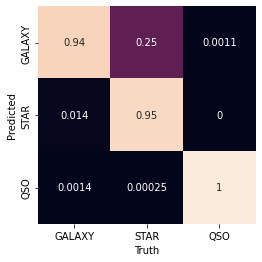

In [128]:
matrix = confusion_matrix(y_pred, y_test)
matrix = matrix / matrix.astype(np.float).sum(axis=1)
cm = sns.heatmap(matrix, square=True, annot=True, cbar=False,
            xticklabels=['GALAXY', 'STAR', 'QSO'], yticklabels=['GALAXY', 'STAR', 'QSO'])
plt.xlabel('Truth')
plt.ylabel('Predicted')
plt.title("")
plt.show()

In [123]:
#initialize shadow tree
sk_dtree = ShadowSKDTree(clf, X, y, features, "class", ['GALAXY', 'STAR', 'QSO'])

[WARNING] [2022-08-09 23:43:03,900:matplotlib.font_manager] findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


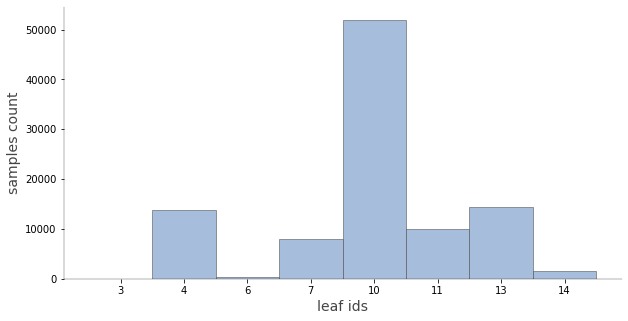

In [130]:
trees.viz_leaf_samples(sk_dtree)

[WARNING] [2022-08-09 23:43:50,124:matplotlib.font_manager] findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
[WARNING] [2022-08-09 23:43:50,353:matplotlib.font_manager] findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
[WARNING] [2022-08-09 23:43:50,369:matplotlib.font_manager] findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3208: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return asarray(a).size
/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1376: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))


[WARNING] [2022-08-09 23:43:51,615:matplotlib.font_manager] findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


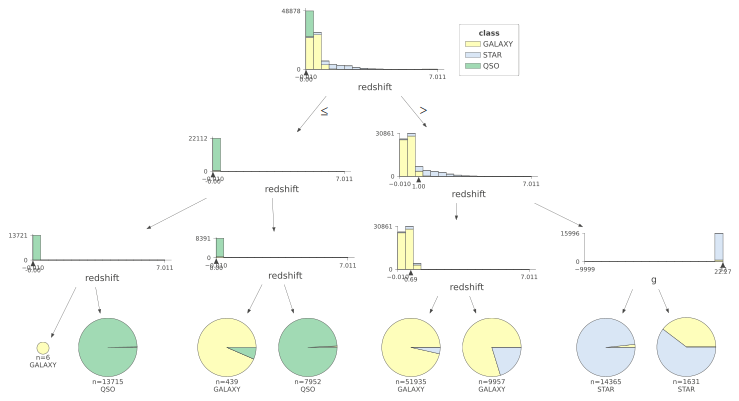

In [132]:
trees.dtreeviz(sk_dtree)


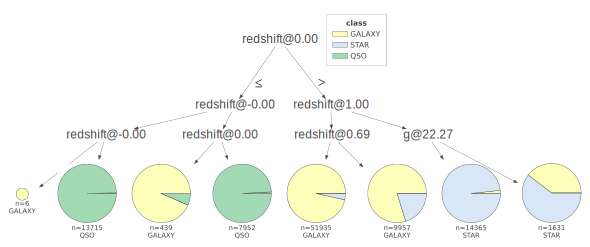

In [133]:
trees.dtreeviz(sk_dtree, fancy=False)

/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3208: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return asarray(a).size
/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1376: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))


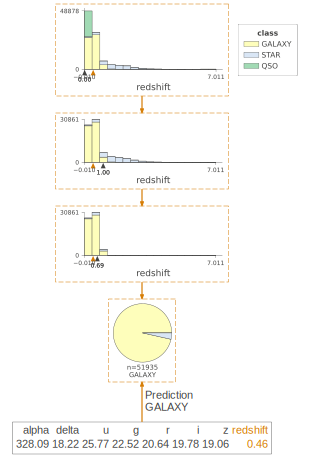

In [136]:
trees.dtreeviz(sk_dtree, show_just_path=True, X = X.iloc[10])

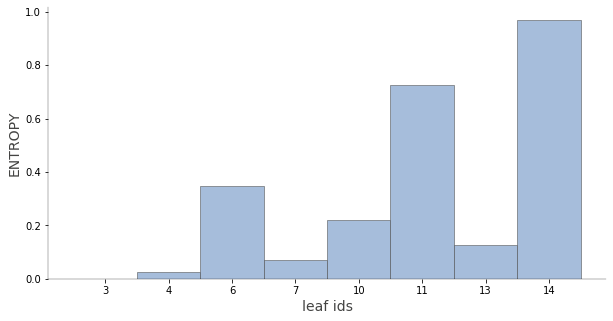

In [138]:
trees.viz_leaf_criterion(clf)


In [139]:
trees.describe_node_sample(sk_dtree, node_id=10)


,alpha,delta,u,g,r,i,z,redshift
count,51935.000000,51935.000000,51935.000000,51935.000000,51935.000000,51935.000000,51935.000000,51935.000000
mean,181.711450,24.074552,22.346448,20.536128,19.210662,18.515720,18.135271,0.355549
std,91.416751,19.351312,2.327826,2.027503,1.723310,1.536114,1.502448,0.203380
min,0.005528,-12.364701,13.897990,12.679020,11.746640,11.299560,10.897380,0.004285
25%,134.238282,6.283251,20.344025,18.611765,17.660465,17.226380,16.926995,0.145027
50%,187.270126,22.799320,22.584700,21.159340,19.592490,18.855040,18.436680,0.387110
75%,231.975632,38.773742,24.060300,22.144885,20.597755,19.655370,19.214630,0.534749
max,359.994125,74.459854,29.325650,29.862580,29.571860,29.889210,29.383740,0.685050


In [141]:
pred_path = X.iloc[10]
pred_path

alpha       328.092076
delta        18.220310
u            25.771630
g            22.520420
r            20.638840
i            19.780710
z            19.057650
redshift      0.459596
Name: 10, dtype: float64

In [143]:
print(trees.explain_prediction_path(clf, pred_path, feature_names=features, explanation_type="plain_english"))


0.0 <= redshift  < 0.69



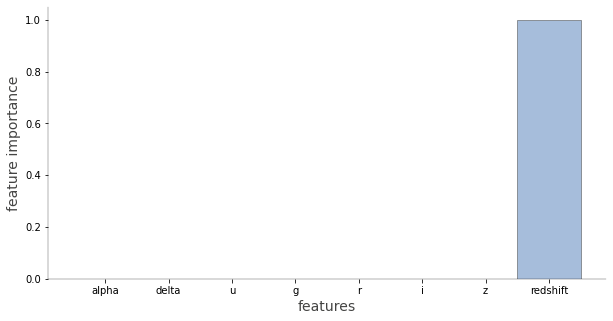

In [144]:
trees.explain_prediction_path(clf, pred_path, feature_names=features, explanation_type="sklearn_default")
